In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
os.chdir("/Users/bytedance/MLTrader-Research/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from research.orderbook_strategies.utils.product_info import product_info
import itertools
import pandas as pd
from collections import OrderedDict
import functools
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask
from dask import compute, delayed
warnings.filterwarnings('ignore')
import scipy
from scipy.stats import norm
import seaborn as sns
product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]
ATR_FILTER = 0.02
MAX_SPREAD_RATIO = 1.1
factor = factors.foctor_kdj_k_period()
# 脚本现在开始
periods = factor.params["period"]
signal_name_format = factor.factor_name

In [3]:
# # %%time
# # 构造因子
for product in product_list:
    file_list = helper.get_file_list(product)
    helper.parLapply(file_list, 
                        factor_analysis.build_composite_signal,
                        signal_list=[factor], 
                        product=product,
                        overwrite=True,)

In [5]:
# 脚本现在开始
periods = [64, 128, 512, 1024, 2048]
signal_name_format = 'kdj.k.{period}'

In [6]:
all_product_signal_periods = {}
for period in periods:
    signal_name = signal_name_format.format(period=period)
    all_product_signal_periods[period] = helper.get_signal_data(product_list, signal_name)
    
tick_ret = helper.get_field_data(product_list, "ret")

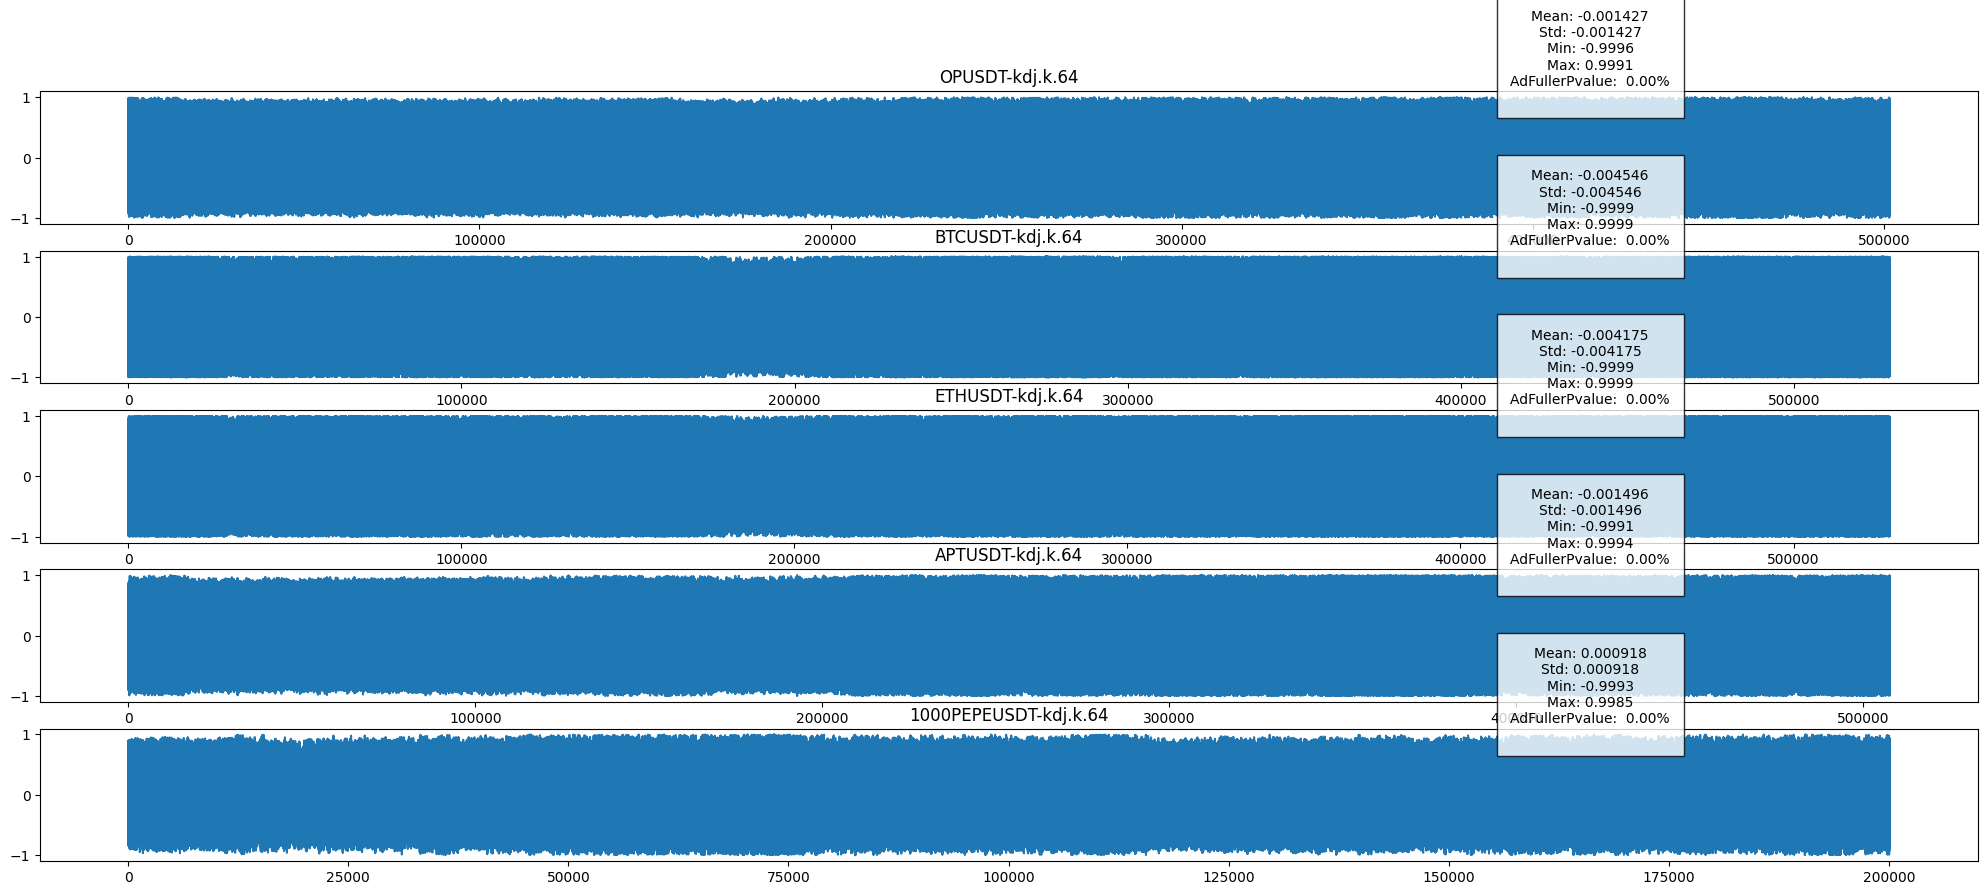

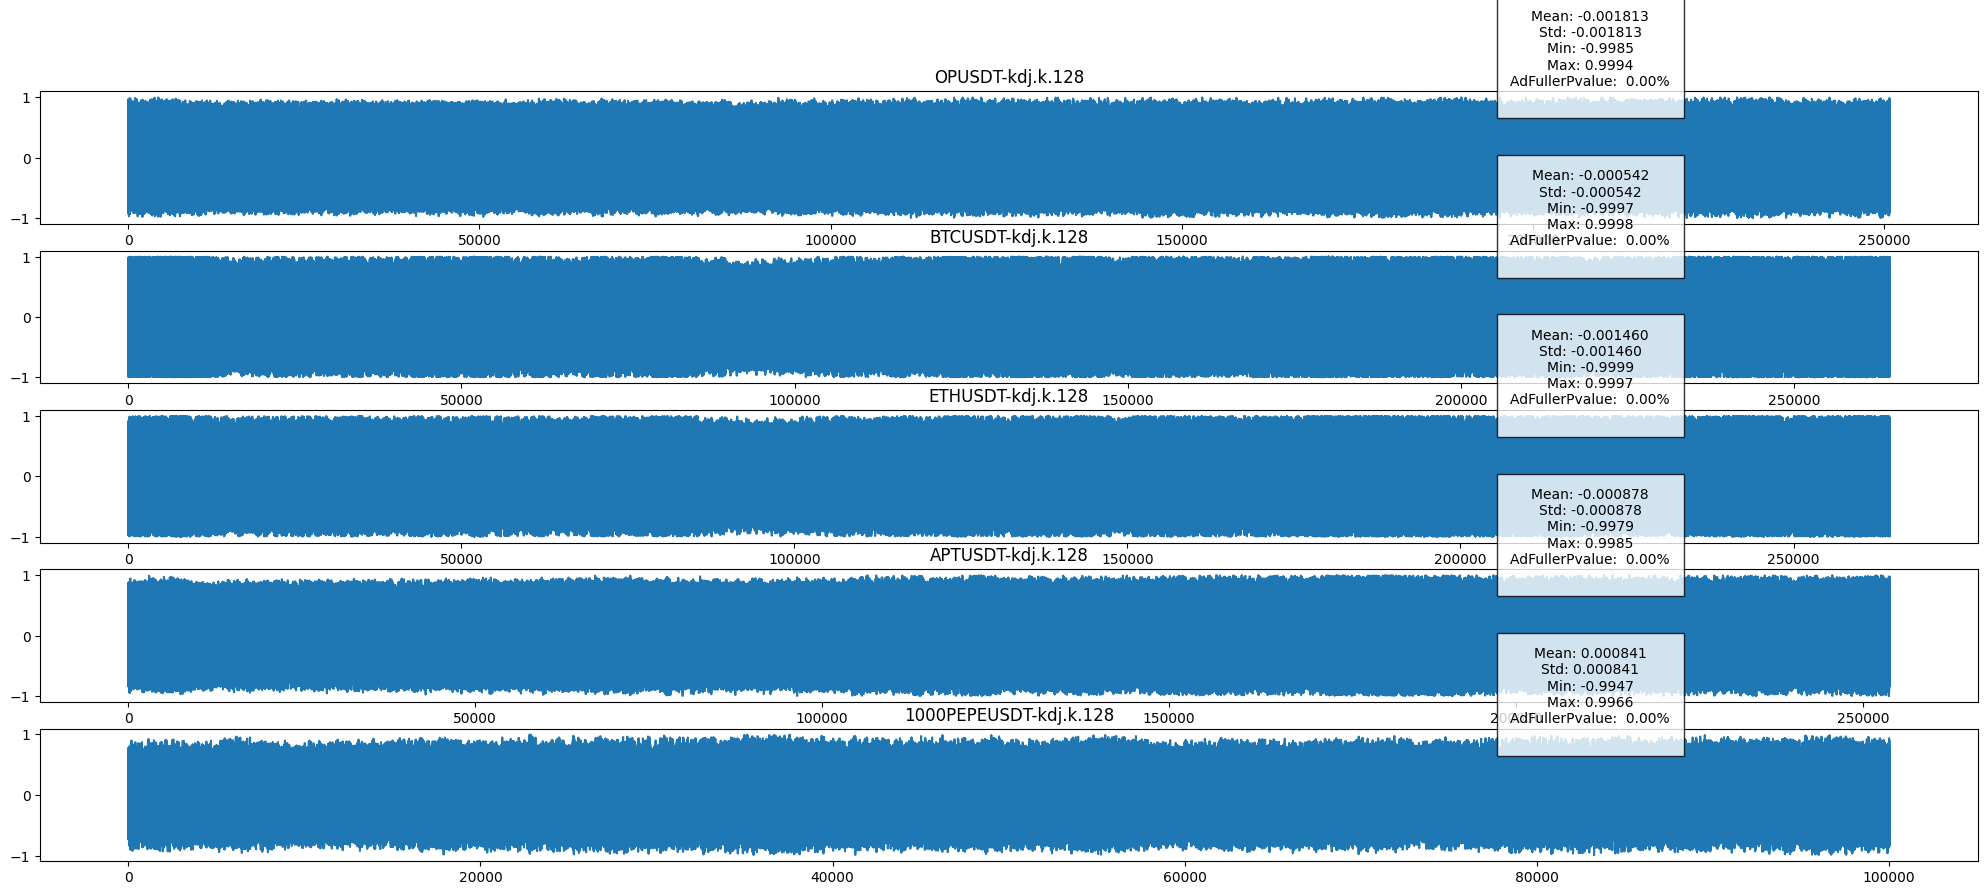

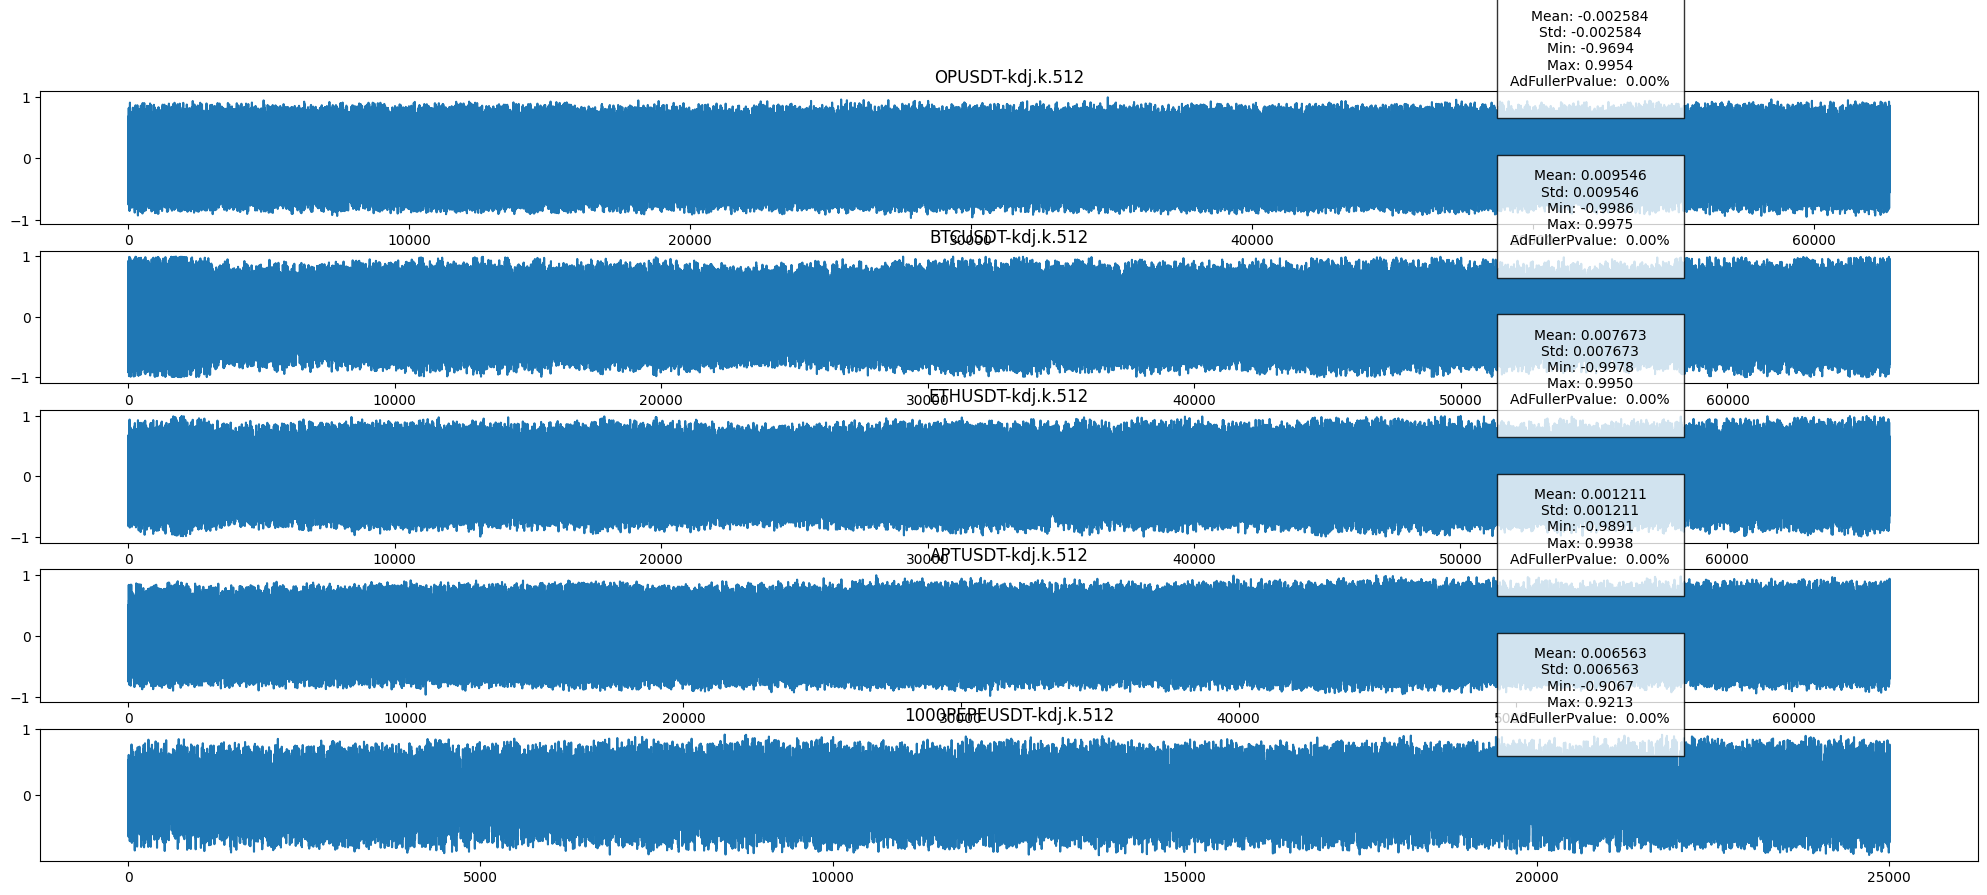

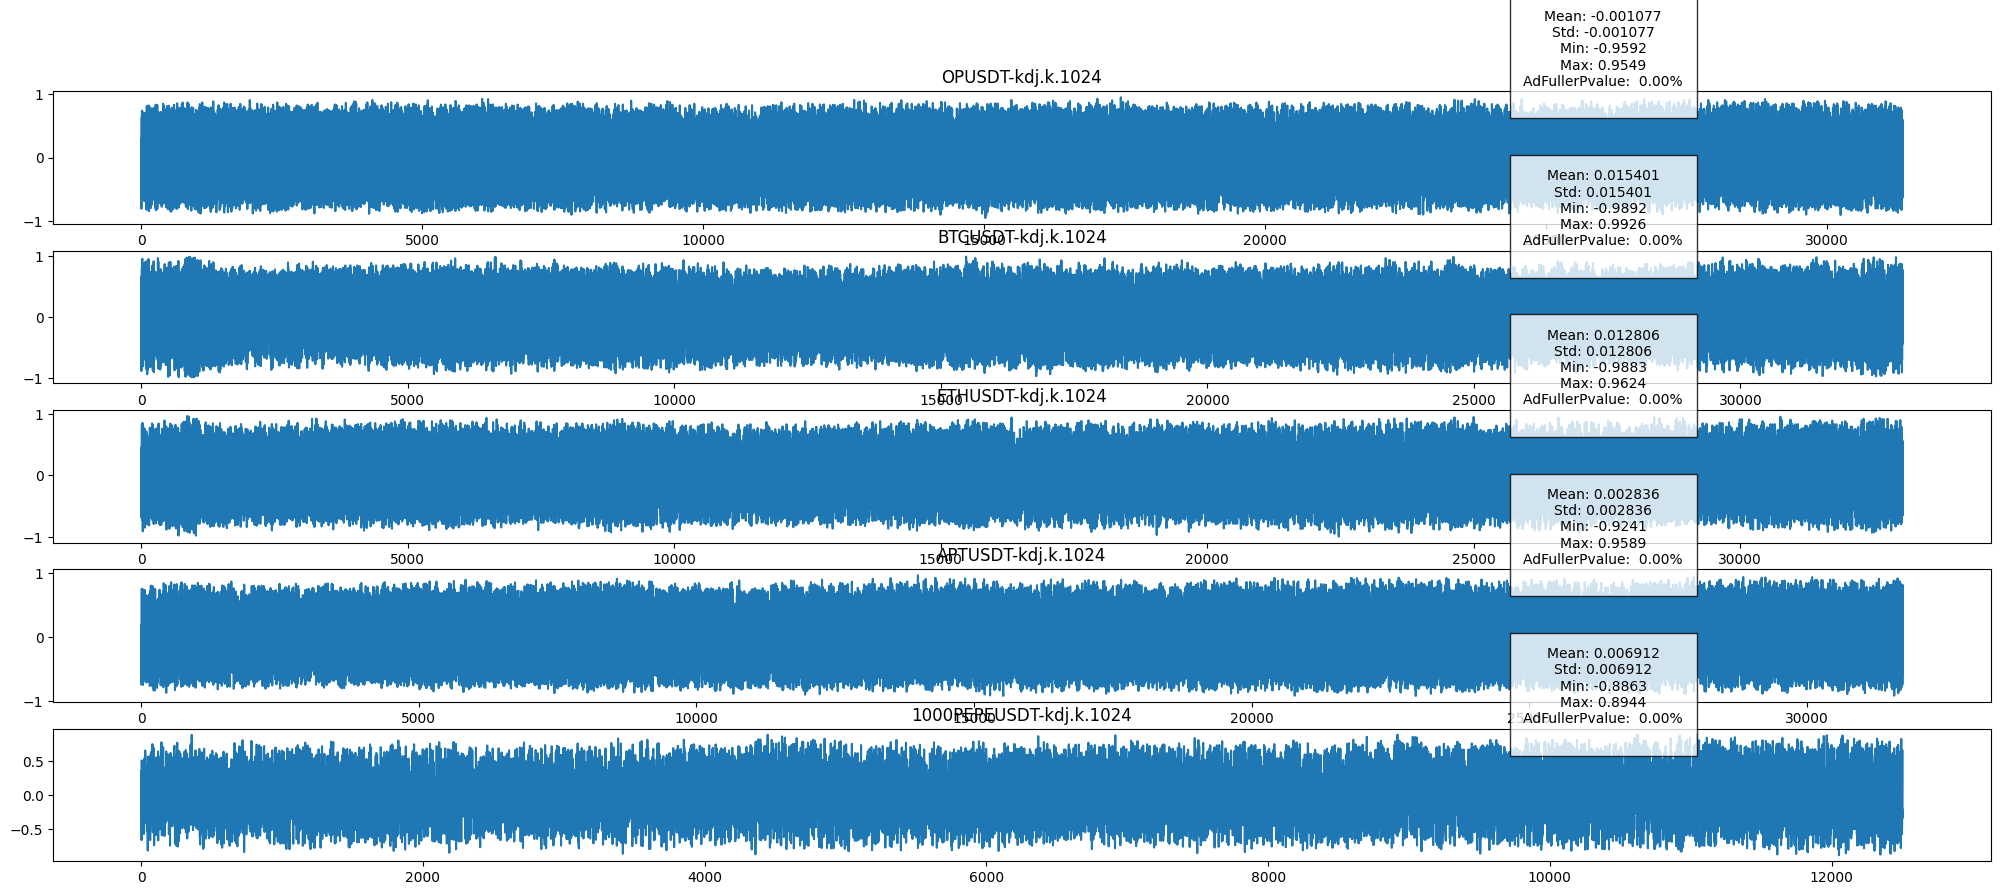

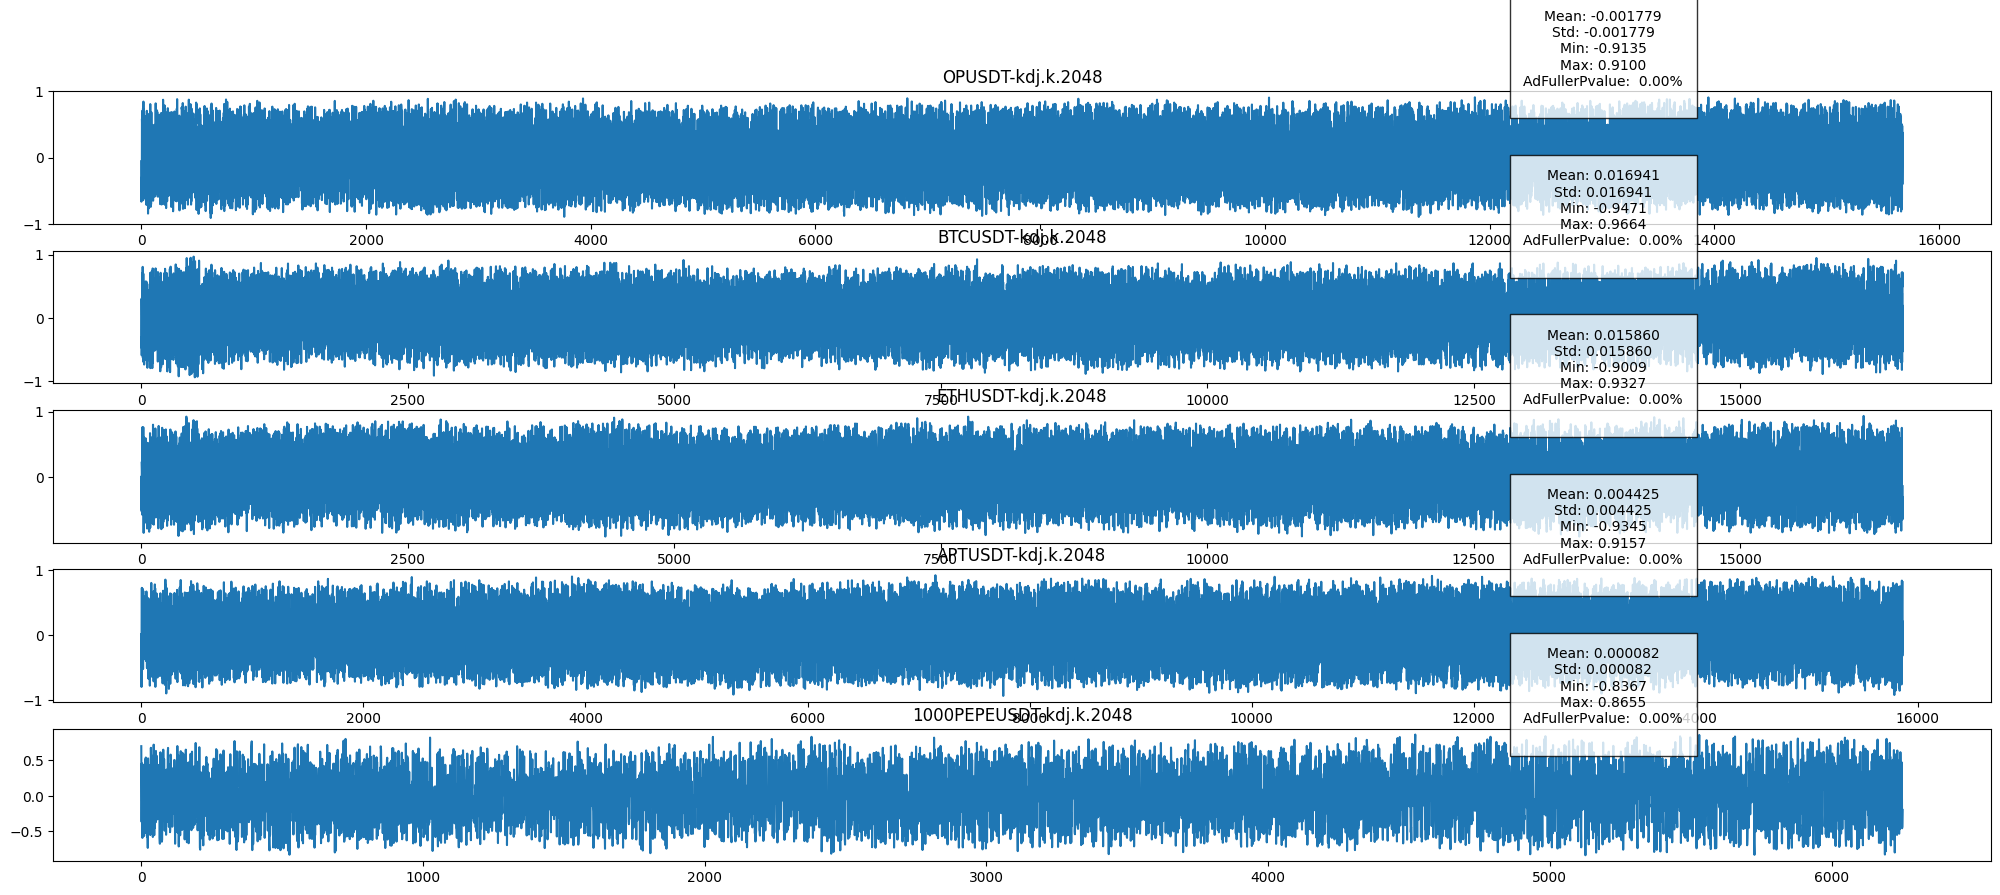

In [7]:
import statsmodels.tsa.stattools as ts
for period in periods:
    f, axes = plt.subplots(len(product_list), 1, figsize=(5 * len(product_list), 10))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        
        T = len(arr)

        arr = arr[np.arange(0, T, period)]
        axes[i].plot(arr)
        axes[i].set_title(product + "-" + signal_name)
        _, p_val, _, _, _ = ts.adfuller(arr, maxlag=int(pow(len(arr)-1,(1/3))), regression='ct', autolag=None)
        
        mean = np.nanmean(arr)
        std = np.nanmean(arr)
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        summary_text = f"Mean: {mean:.6f}\nStd: {std:.6f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}\nAdFullerPvalue: {p_val: .2%}\n"
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

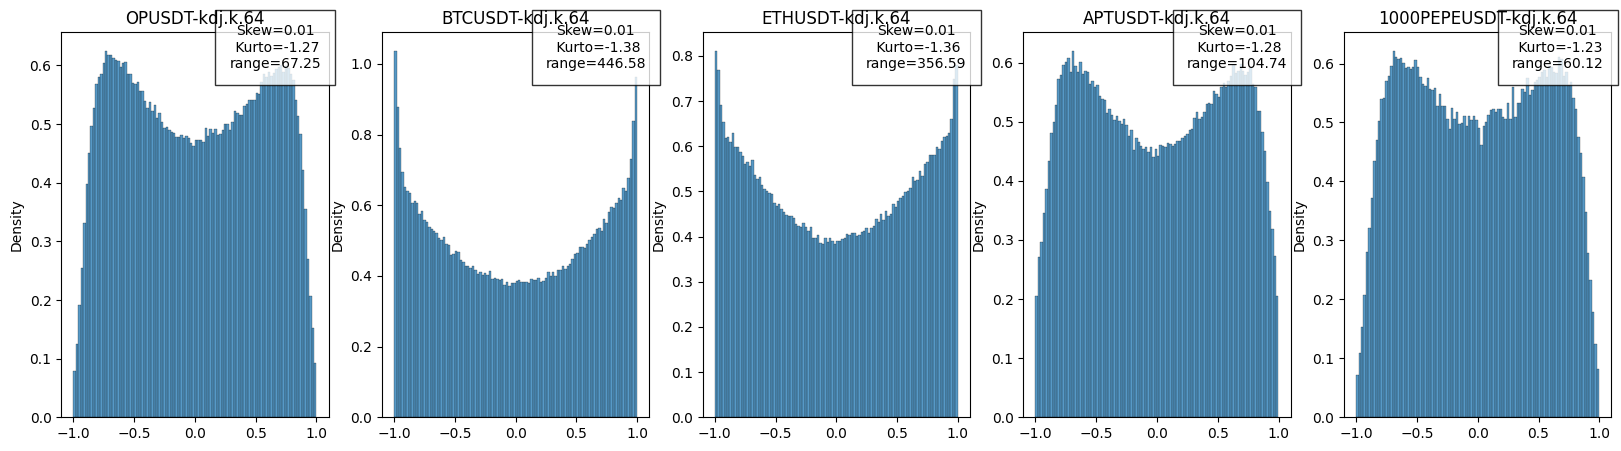

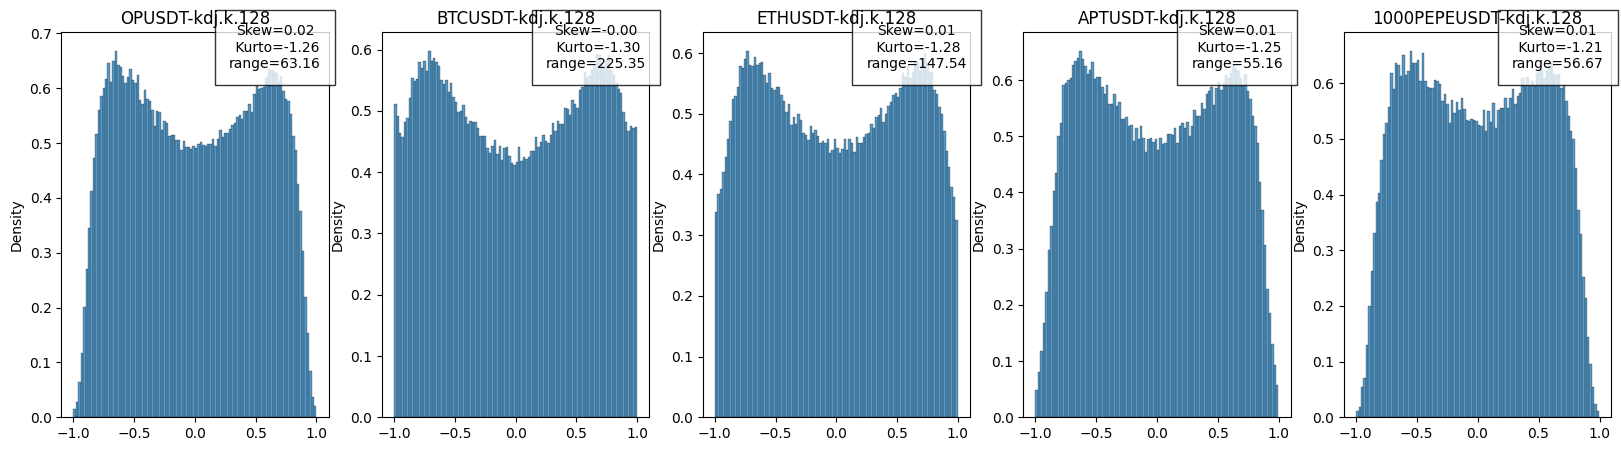

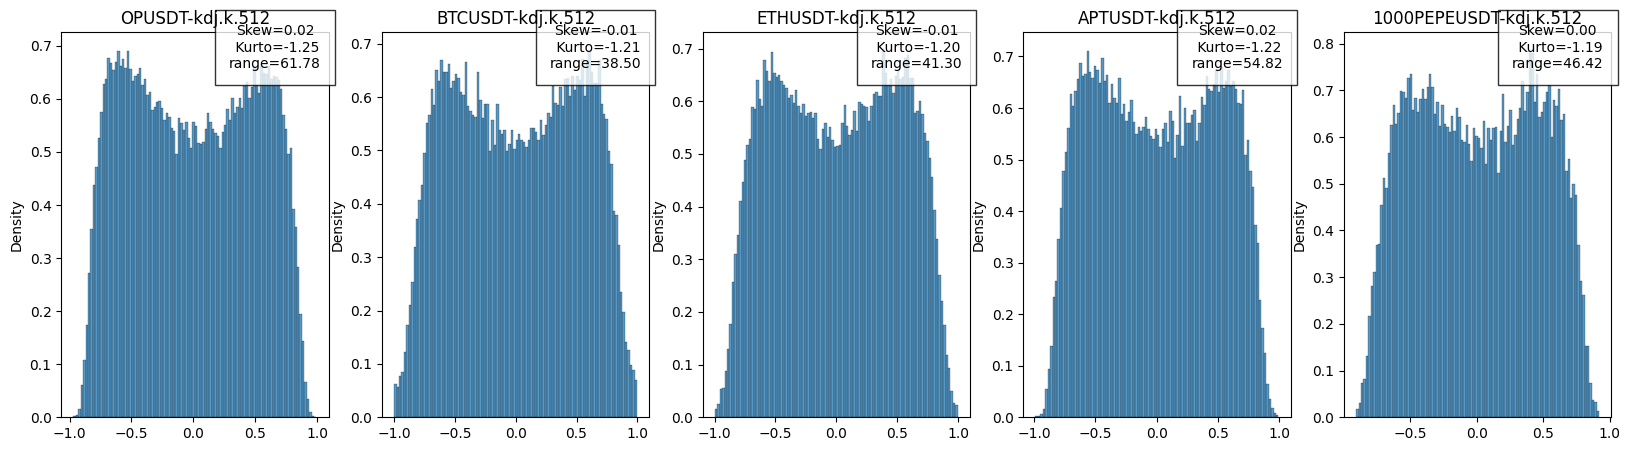

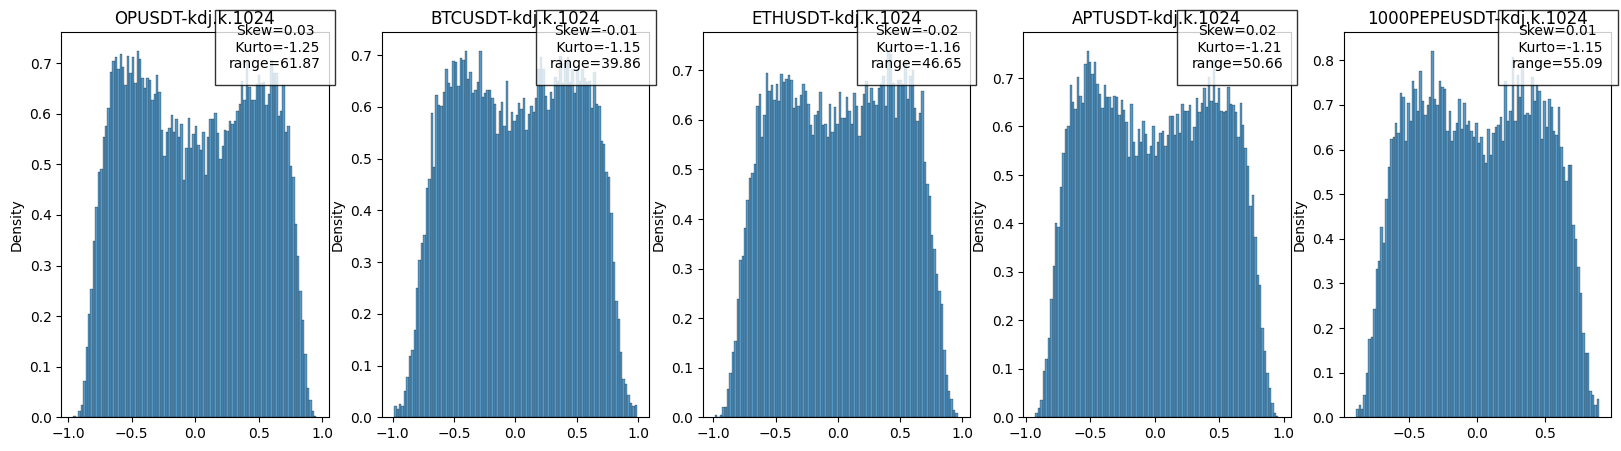

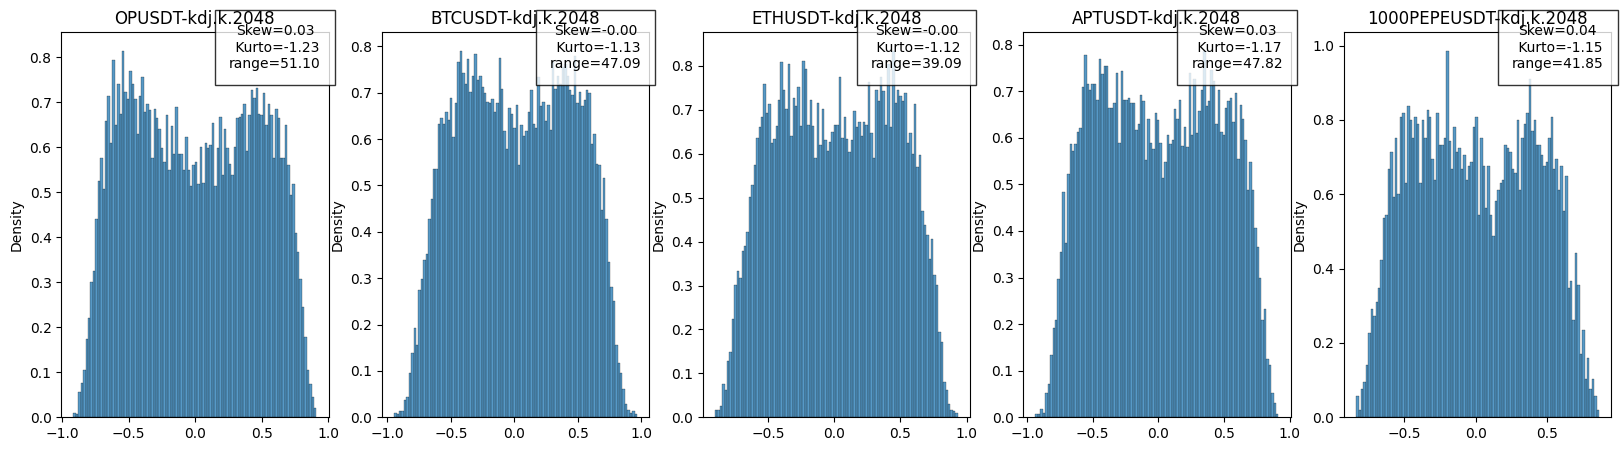

In [8]:
for period in periods:
    f, axes = plt.subplots(1, len(product_list), figsize=(20, 5))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        T = len(arr)
        arr = arr[np.arange(0, T, period)]
        skew = scipy.stats.skew(arr)
        kurto = scipy.stats.kurtosis(arr)
        max_min_range = (np.nanmax(arr) - np.nanmin(arr)) / (np.percentile(arr, 0.75) - np.percentile(arr, 0.25))
        summary_text = f"Skew={skew:.2f}\n Kurto={kurto:.2f}\nrange={max_min_range:.2f}"
        # Plot the empirical histogram
        sns.histplot(arr, kde=False, bins=100, stat='density', label='Empirical', ax=axes[i])

        # # Fit a normal distribution to the data
        # mean, std = norm.fit(data)

        # # Generate values for the estimated normal distribution
        # x = np.linspace(min(data), max(data), 100)
        # y = norm.pdf(x, mean, std)

        # axes[i].plot(x, y, label='Estimated', color='red')
        axes[i].set_title(product + "-" + signal_name)
        
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

64 OPUSDT 64 BTCUSDT 64 ETHUSDT 64 APTUSDT 64 1000PEPEUSDT 128 OPUSDT 128 BTCUSDT 128 ETHUSDT 128 APTUSDT 128 1000PEPEUSDT 512 OPUSDT 512 BTCUSDT 512 ETHUSDT 512 APTUSDT 512 1000PEPEUSDT 1024 OPUSDT 1024 BTCUSDT 1024 ETHUSDT 1024 APTUSDT 1024 1000PEPEUSDT 2048 OPUSDT 2048 BTCUSDT 2048 ETHUSDT 2048 APTUSDT 2048 1000PEPEUSDT 

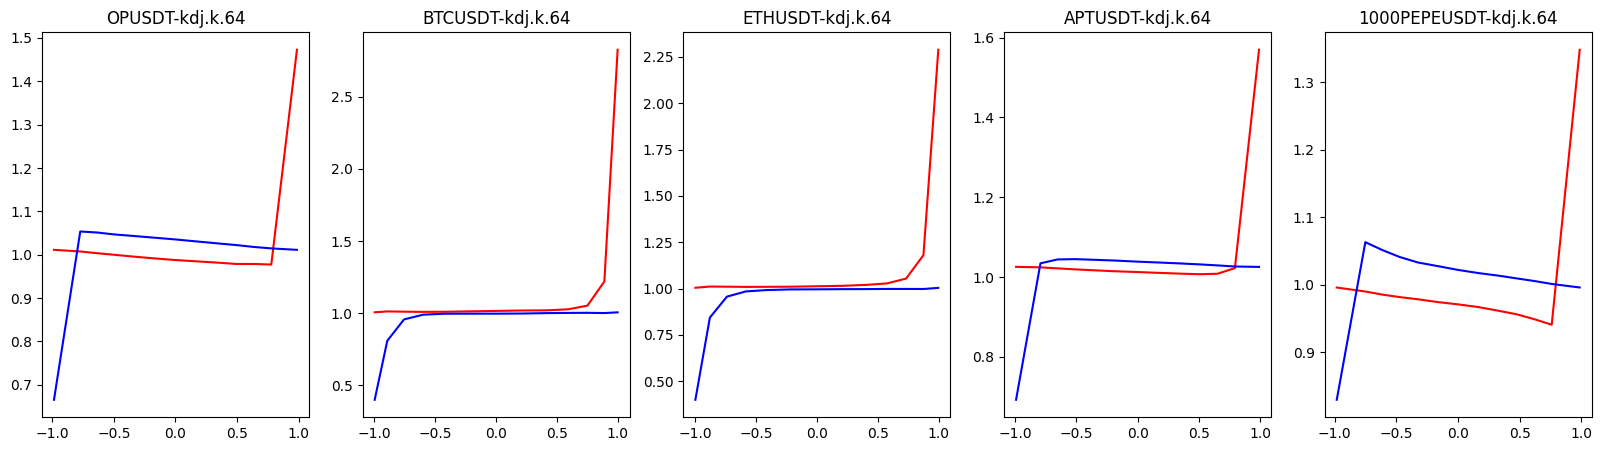

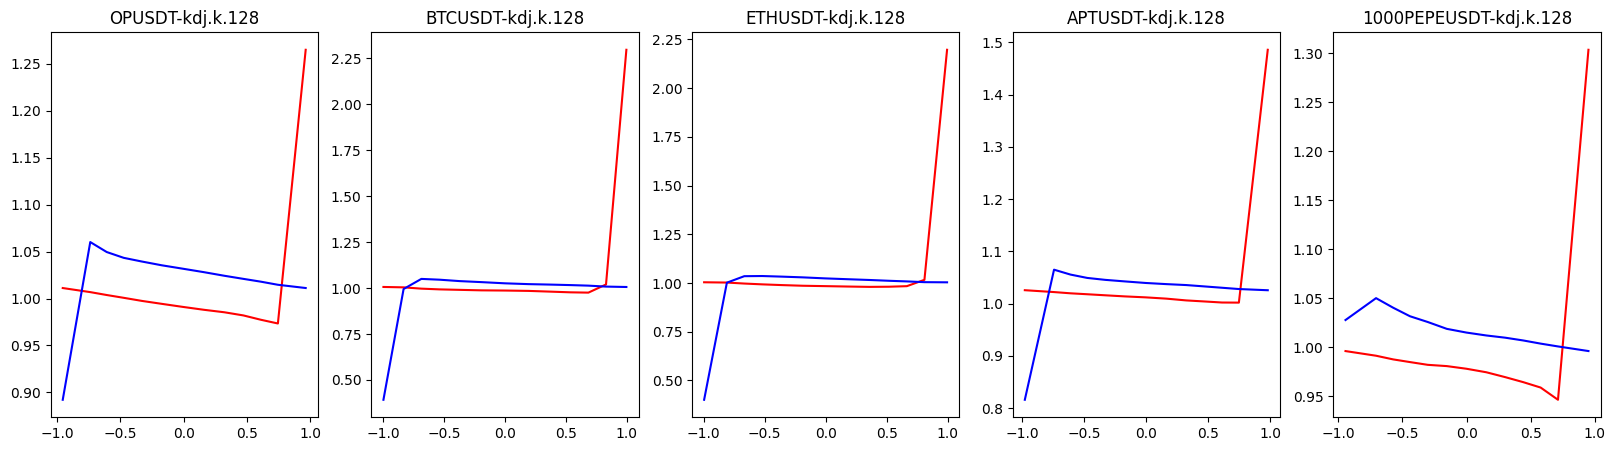

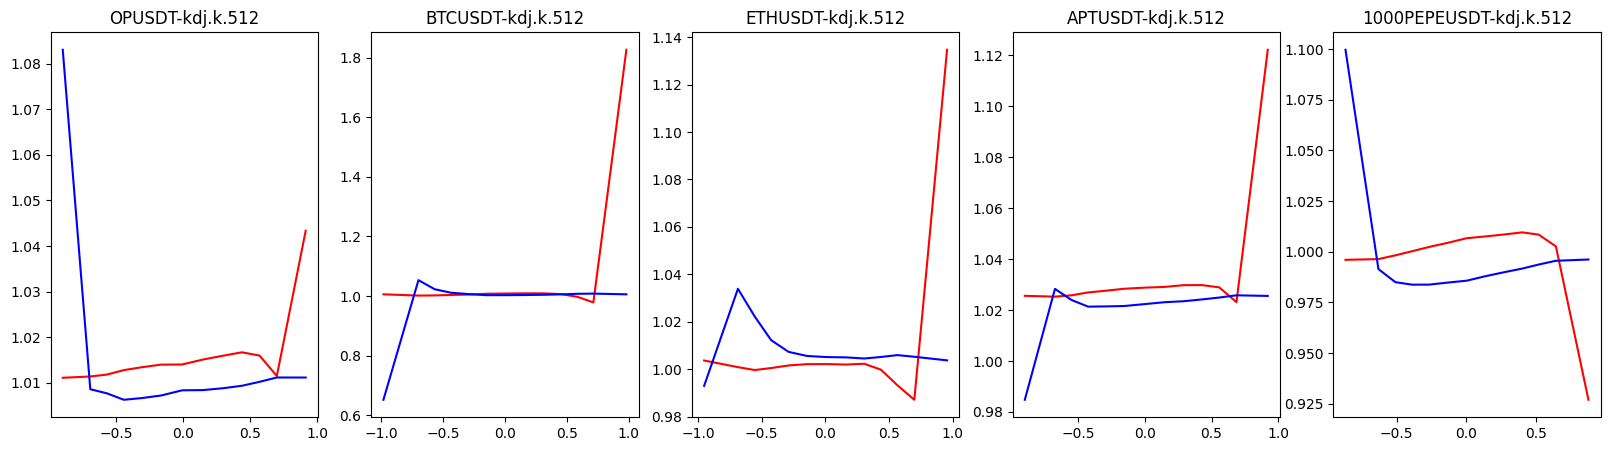

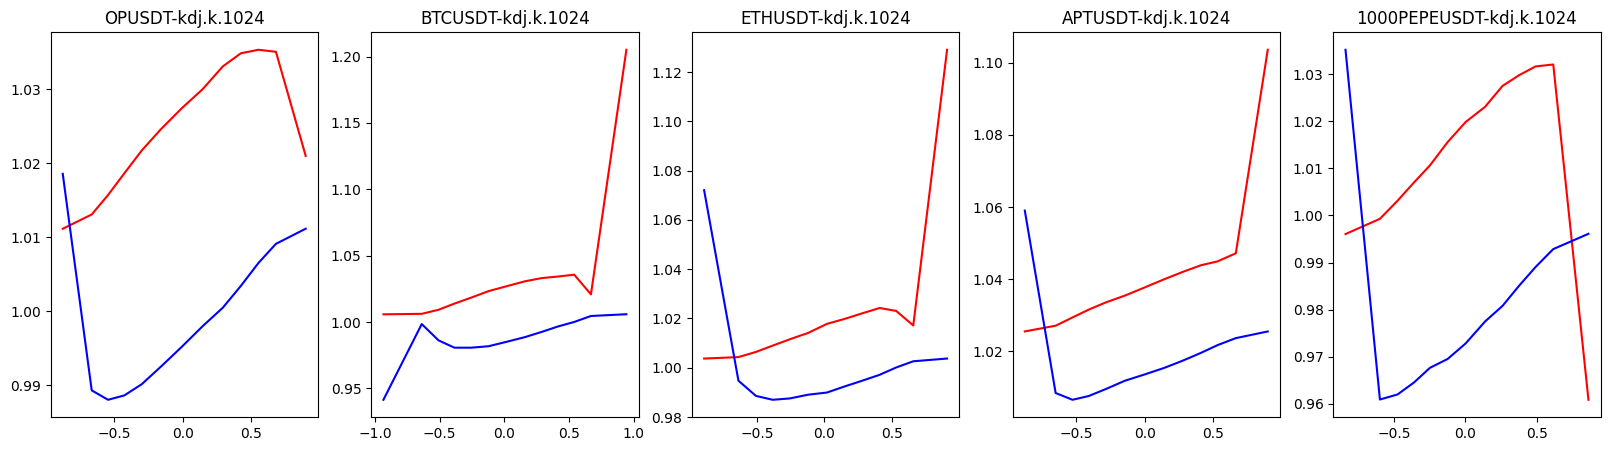

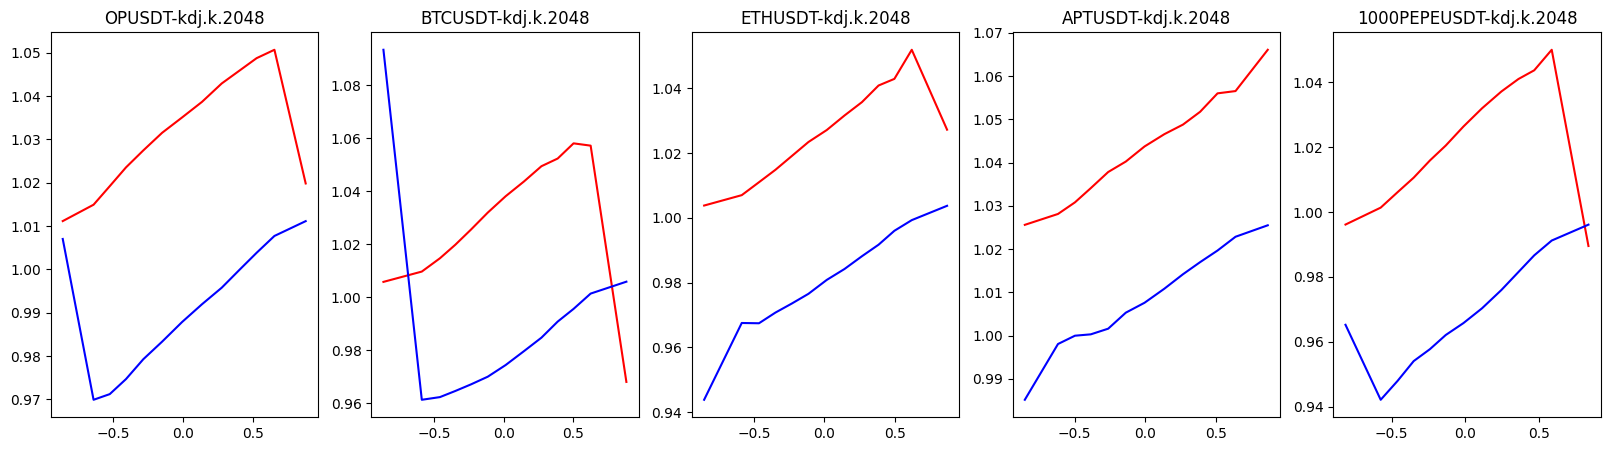

In [9]:
for period in periods:
    f, axes = plt.subplots(1, len(product_list), figsize=(20, 5))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        roc_results = factor_analysis.quick_roc_test(signal_name, product, N_threshold=13)
        axes[i].plot(roc_results["threshold"], roc_results["long_pf"], label='profit_factor(long)', color='red')
        axes[i].plot(roc_results["threshold"], roc_results["short_pf"], label='profit_factor(short)', color='blue')
        axes[i].set_title(product + "-" + signal_name)
        print(str(period) + " " + product, end=" ")
        
    f.show()

In [2]:
trades_signal_period = [signal_name_format.format(period=period) for period in periods]
results = factor_analysis.get_signal_performance_result(trades_signal_period, "signal_result_with_atr", product_list, 1e-4, 1)

trend_res = results['trend.signal.stat']
reve_res = results["reverse.signal.stat"]
signal_trend_res = trend_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']
signal_rever_res = reve_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']

trend_signals = signal_trend_res[(signal_trend_res - signal_rever_res) > 0].index
reverse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) < 0].index
nouse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) == 0].index

print("#trend={}, #reverse={}, #nouse={}".format(len(trend_signals), len(reverse_signals), len(nouse_signals)))

merge_res = pd.concat([trend_res.loc[np.isin(trend_res['signal'], trend_signals)], 
                       reve_res.loc[np.isin(reve_res['signal'], reverse_signals)]], 
                      axis=0)

display(merge_res.sort_values(by='trainSharpe', ascending=False))

#trend=4, #reverse=3, #nouse=0


,signal,reverse,num_good_product,good_product,good_product_sharpe,trainSharpe,testSharpe,trainSharpeV2,testSharpeV2,trainAvgDailyTradeNum,testAvgDailyTradeNum,sum_good_strat,avgTrainRet,avgTestRet,trainReturn,testReturn
0,kdj.k.32,reverse,2,"BTCUSDT,ETHUSDT","5.6,2.86",4.229345,2.789503,5.602341,5.161455,50.783587,38.246154,10,0.003965,0.001580,0.932386,0.205451
1,kdj.k.64,reverse,3,"BTCUSDT,ETHUSDT,1000PEPEUSDT","4.63,4.6,1.67",3.631148,1.868213,4.631672,5.614714,76.679746,49.007543,35,0.004547,-0.000224,0.734315,0.072546
2,kdj.k.128,reverse,5,"OPUSDT,BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT","1.45,4.9,5.13,2.71,3.59",3.556452,1.641319,1.454211,-1.680418,145.497059,103.410684,81,0.004715,0.000332,0.794998,0.040174
4,kdj.k.512,trend,2,"APTUSDT,1000PEPEUSDT","1.6,4.93",3.263963,-0.798642,1.602197,-1.430767,23.066844,25.937305,67,0.007902,-0.000699,0.421968,-0.080648
5,kdj.k.1024,trend,2,"APTUSDT,1000PEPEUSDT","1.62,4.12",2.869900,-1.507828,1.615291,-1.538829,19.205489,21.250602,53,0.011363,-0.002444,0.609210,-0.208923
3,kdj.k.256,reverse,5,"OPUSDT,BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT","1.98,2.69,3.38,3.27,2.77",2.820659,0.673601,1.982944,-1.734478,114.864992,81.303888,77,0.004226,0.000050,0.722225,-0.033607
6,kdj.k.2048,trend,5,"OPUSDT,BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT","0.66,0.67,1.0,1.79,1.89",1.203827,-0.802965,0.663619,-1.573806,28.668176,25.894563,63,0.003561,-0.001575,0.443694,-0.165868
